In [32]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt



In [33]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True


In [34]:
if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())



{'login': 213644473, 'trade_mode': 0, 'leverage': 1000, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 200.0, 'credit': 0.0, 'profit': 0.0, 'equity': 200.0, 'margin': 0.0, 'margin_free': 200.0, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'micheal bright omage ', 'server': 'OctaFX-Demo', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': False, 'build': 5200, 'maxbars': 100000, 'codepage': 0, 'ping_last': 136559, 'community_balance': 0.0, 'retransmission': 0.4690881441188513, 'company': 'Meta

In [35]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True and terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

200.0
AI is successfully functional


In [36]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = ["GBPUSD","EURUSD","USDCAD","USDJPY","AUDUSD"]
for symbol in symbols:
    for t_s in t_symbol:
        if(symbol.name == t_s):
            print("yes ",t_s)
            break



280
yes  EURUSD
yes  GBPUSD
yes  USDJPY
yes  AUDUSD
yes  USDCAD


In [37]:
n = 0

In [38]:
market = mt5.copy_rates_from_pos(t_symbol[n], mt5.TIMEFRAME_H1, 0, 99999)

In [39]:
market

array([(1248706800, 1.6501 , 1.651  , 1.6487 , 1.649  , 1175, 20, 0),
       (1248710400, 1.6489 , 1.6512 , 1.6458 , 1.6497 , 1318, 20, 0),
       (1248714000, 1.6496 , 1.6504 , 1.6481 , 1.6486 ,  718, 20, 0), ...,
       (1756872000, 1.33751, 1.33773, 1.33668, 1.33689, 2923, 13, 0),
       (1756875600, 1.33688, 1.33747, 1.33629, 1.3365 , 2347, 13, 0),
       (1756879200, 1.33649, 1.33697, 1.33649, 1.33689,  457, 13, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [40]:
len(market)

99999

In [41]:
data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4]])

In [42]:
df = pd.DataFrame(data, columns=["open", "high","low", "close"])
display(df)

,open,high,low,close
0,1.65010,1.65100,1.64870,1.64900
1,1.64890,1.65120,1.64580,1.64970
2,1.64960,1.65040,1.64810,1.64860
3,1.64850,1.65050,1.64850,1.64940
4,1.64960,1.65010,1.64780,1.64960
...,...,...,...,...
99994,1.33867,1.33873,1.33809,1.33809
99995,1.33809,1.33828,1.33716,1.33751
99996,1.33751,1.33773,1.33668,1.33689
99997,1.33688,1.33747,1.33629,1.33650


In [43]:
df.to_csv("Generated"+t_symbol[n]+" dbot.csv", index=False)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf


In [2]:
train_df = pd.read_csv("GeneratedGBPUSD dbot.csv")
display(train_df)

,open,high,low,close
0,1.65010,1.65100,1.64870,1.64900
1,1.64890,1.65120,1.64580,1.64970
2,1.64960,1.65040,1.64810,1.64860
3,1.64850,1.65050,1.64850,1.64940
4,1.64960,1.65010,1.64780,1.64960
...,...,...,...,...
99994,1.33867,1.33873,1.33809,1.33809
99995,1.33809,1.33828,1.33716,1.33751
99996,1.33751,1.33773,1.33668,1.33689
99997,1.33688,1.33747,1.33629,1.33650


In [3]:
# -------------------------
# User-adjustable settings
# -------------------------
SEQ_LEN = 24              # length of input sequence (timesteps). Typical choices: 30, 60, 90
MODEL_SAVE_PATH = 'lstm_multivar_best.keras'

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [5]:
def create_sequences(data_scaled, seq_len):
    """
    data_scaled: np.array shaped (n_rows, n_features)
    returns X (n_samples, seq_len, n_features), y (n_samples, n_features)
    where y is the row immediately following the window.
    """
    X, y = [], []
    n_rows = data_scaled.shape[0]
    for i in range(n_rows - seq_len):
        X.append(data_scaled[i:i+seq_len])
        y.append(data_scaled[i+seq_len])
    X = np.array(X)
    y = np.array(y)
    return X, y

# 1) Convert to numpy and ensure numeric
n_rows, n_features = train_df.values.shape
"""
# 2) Fit scaler on all feature columns (important to use same scaler for inverse transform)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all = scaler.fit_transform(train_df.values)  # (n_rows, n_features)
"""
# 3) Build sequences
X, y = create_sequences(train_df.values[:,-1], SEQ_LEN)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)

n_samples = X.shape[0]


In [6]:
X = X.reshape((X.shape[0],X.shape[1],1))
y = y.reshape((y.shape[0],1,1))

In [7]:
print(X[-1])
print(y[-1])

[[1.35253]
 [1.35269]
 [1.35205]
 [1.35306]
 [1.34026]
 [1.34127]
 [1.33987]
 [1.33781]
 [1.3383 ]
 [1.3351 ]
 [1.33864]
 [1.33966]
 [1.33891]
 [1.33918]
 [1.33835]
 [1.33787]
 [1.33899]
 [1.33922]
 [1.33918]
 [1.33863]
 [1.33809]
 [1.33751]
 [1.33689]
 [1.3365 ]]
[[1.33689]]


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45, shuffle=True)

In [10]:
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=45, shuffle=True)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)


(74981, 24, 1)
(74981, 1, 1)
(250, 24, 1)
(250, 1, 1)
(24744, 24, 1)
(24744, 1, 1)


In [12]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt


import json
import math
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [13]:
  # 5) Build model
seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))
X = LSTM(200, return_sequences=True)(i)
X = LSTM(200, return_sequences=True)(X)
X = LSTM(200, return_sequences=True)(X)
X = LSTM(200)(X)
X = Dense(200, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 24, 200)           320800    
                                                                 
 lstm_2 (LSTM)               (None, 24, 200)           320800    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dropout (Dropout)           (None, 200)               0     

In [14]:
# 6) Callbacks
es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=2)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae'])


In [16]:
r = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    #batch_size=128,
    callbacks=[es, rlr, mc ],
    verbose=2

)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00037, saving model to lstm_multivar_best.keras
2344/2344 - 54s - loss: 0.0469 - mae: 0.1584 - val_loss: 3.7137e-04 - val_mae: 0.0170 - lr: 1.0000e-04 - 54s/epoch - 23ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.00037 to 0.00021, saving model to lstm_multivar_best.keras
2344/2344 - 46s - loss: 0.0303 - mae: 0.1379 - val_loss: 2.1497e-04 - val_mae: 0.0124 - lr: 1.0000e-04 - 46s/epoch - 20ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00021
2344/2344 - 48s - loss: 0.0257 - mae: 0.1270 - val_loss: 0.0018 - val_mae: 0.0418 - lr: 1.0000e-04 - 48s/epoch - 20ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.00021 to 0.00007, saving model to lstm_multivar_best.keras
2344/2344 - 47s - loss: 0.0217 - mae: 0.1169 - val_loss: 6.9953e-05 - val_mae: 0.0066 - lr: 1.0000e-04 - 47s/epoch - 20ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00007
2344/2344 - 46s - loss: 0.0183 - mae: 0.1069 - val_loss: 9.271

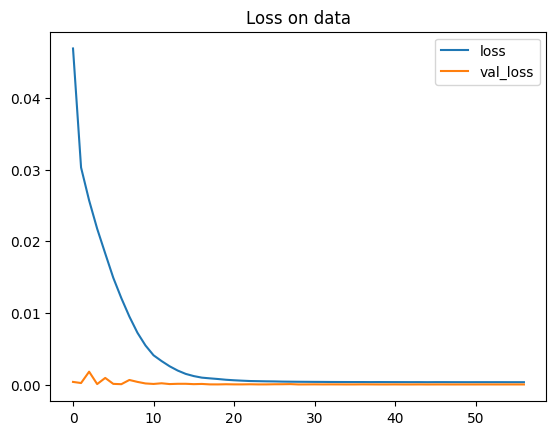

In [17]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

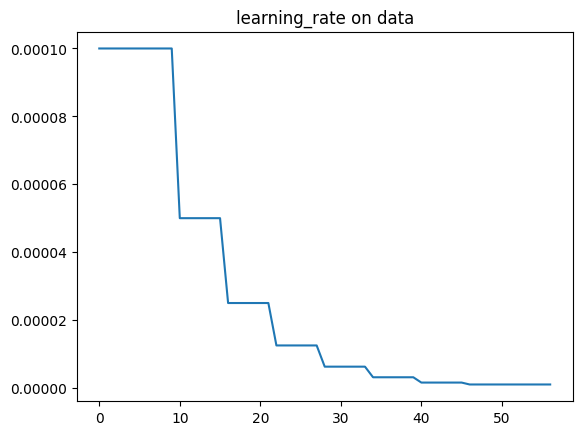

In [20]:
plt.title("learning_rate on data")
plt.plot(r.history['lr'], label="loss")

plt.show()

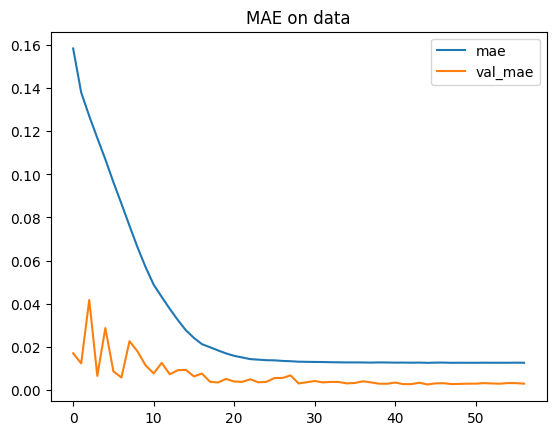

In [21]:
plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

In [22]:
from tensorflow.keras.models import load_model
best_model = load_model(MODEL_SAVE_PATH)

In [23]:
y_pred = best_model.predict(X_test)
print(y_pred)

8/8 [==============================] - 1s 20ms/step
[[1.273733 ]
 [1.581281 ]
 [1.4758118]
 [1.291988 ]
 [1.2663487]
 [1.2008423]
 [1.2317976]
 [1.2887808]
 [1.2735614]
 [1.2879883]
 [1.2887791]
 [1.2772944]
 [1.5348359]
 [1.5909998]
 [1.6097552]
 [1.6005424]
 [1.3081516]
 [1.1511259]
 [1.5621037]
 [1.6241736]
 [1.2590227]
 [1.3829849]
 [1.3429992]
 [1.2556354]
 [1.2169898]
 [1.5160987]
 [1.2610164]
 [1.3045976]
 [1.3167269]
 [1.1576111]
 [1.3663827]
 [1.4841609]
 [1.3146199]
 [1.661647 ]
 [1.5108001]
 [1.2198623]
 [1.5327667]
 [1.2494262]
 [1.2455163]
 [1.2227775]
 [1.1652336]
 [1.296475 ]
 [1.2404273]
 [1.5567755]
 [1.3143803]
 [1.5480974]
 [1.5165489]
 [1.6279385]
 [1.5215237]
 [1.2577245]
 [1.2933034]
 [1.6864562]
 [1.1348246]
 [1.4528837]
 [1.2694839]
 [1.2883904]
 [1.5585687]
 [1.2702144]
 [1.2756736]
 [1.6239493]
 [1.5164764]
 [1.637191 ]
 [1.272775 ]
 [1.2400166]
 [1.670196 ]
 [1.3597085]
 [1.3758806]
 [1.5310702]
 [1.6222703]
 [1.2986213]
 [1.5803413]
 [1.2733655]
 [1.2500842]

In [24]:
print(y_test)

[[[1.27175]]

 [[1.58612]]

 [[1.47495]]

 [[1.29011]]

 [[1.2663 ]]

 [[1.19449]]

 [[1.22896]]

 [[1.28482]]

 [[1.2738 ]]

 [[1.28697]]

 [[1.28712]]

 [[1.28091]]

 [[1.53448]]

 [[1.59242]]

 [[1.61136]]

 [[1.60176]]

 [[1.31012]]

 [[1.15136]]

 [[1.56158]]

 [[1.61777]]

 [[1.2599 ]]

 [[1.38302]]

 [[1.34378]]

 [[1.25438]]

 [[1.21576]]

 [[1.52632]]

 [[1.25983]]

 [[1.30299]]

 [[1.31744]]

 [[1.16137]]

 [[1.36967]]

 [[1.48216]]

 [[1.31247]]

 [[1.66139]]

 [[1.51141]]

 [[1.22135]]

 [[1.539  ]]

 [[1.24789]]

 [[1.24188]]

 [[1.22559]]

 [[1.16928]]

 [[1.29878]]

 [[1.24064]]

 [[1.55616]]

 [[1.31235]]

 [[1.54783]]

 [[1.51466]]

 [[1.6338 ]]

 [[1.52287]]

 [[1.25917]]

 [[1.29253]]

 [[1.68804]]

 [[1.12221]]

 [[1.45941]]

 [[1.2725 ]]

 [[1.28979]]

 [[1.55911]]

 [[1.26636]]

 [[1.27163]]

 [[1.62411]]

 [[1.5171 ]]

 [[1.63698]]

 [[1.27152]]

 [[1.24598]]

 [[1.67013]]

 [[1.36064]]

 [[1.37547]]

 [[1.53096]]

 [[1.62422]]

 [[1.29764]]

 [[1.58781]]

 [[1.2

In [25]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

ValueError: Found array with dim 3. None expected <= 2.

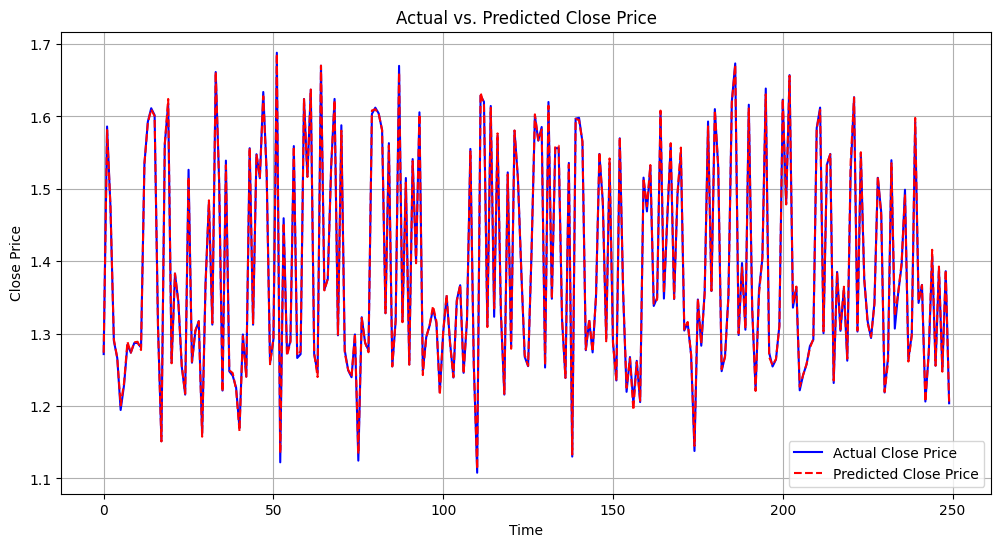

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual Close Price', color='blue')
plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()

In [28]:
# Save this as plot_forecast.py and run where your model, x_test, y_test (and optional scalers) are available.

import numpy as np
import matplotlib.pyplot as plt

def ensure_2d_preds(preds):
    """Normalize model.predict outputs to shape (n_samples, n_features)."""
    preds = np.asarray(preds)
    if preds.ndim == 3:
        # common case: (n_samples, 1, n_features) or (n_samples, seq_len, n_features)
        # we assume model outputs final-step predictions if seq_len>1
        if preds.shape[1] == 1:
            preds = preds[:, 0, :]
        else:
            preds = preds[:, -1, :]
    elif preds.ndim == 1:
        preds = preds.reshape(-1, 1)
    return preds

def plot_test_vs_pred_close(y_test, preds, output_index=-1, figsize=(12,5), savepath=None):
    """
    Plot actual vs predicted for the 'close' column (default last column).
    y_test: (n, n_features)
    preds: (n, n_features)
    """
    y_test = np.asarray(y_test)
    preds = np.asarray(preds)
    # normalize shapes
    preds = ensure_2d_preds(preds)

    actual_close = y_test[:, output_index]
    pred_close   = preds[:, output_index]

    plt.figure(figsize=figsize)
    plt.plot(actual_close, label='Actual Close')
    plt.plot(pred_close, label='Predicted Close')
    plt.xlabel('Time (test index)')
    plt.ylabel('Close price')
    plt.title('Actual vs Predicted Close Price (test set)')
    plt.legend()
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def recursive_forecast(model, last_window, n_steps=2000):
    """
    Do recursive multi-step forecasting:
      - model.predict expects input shape (1, window_len, n_features)
      - last_window: shape (window_len, n_features)
      - returns array shape (n_steps, n_features)
    """
    last_window = np.asarray(last_window).astype(np.float32)
    if last_window.ndim != 2:
        raise ValueError("last_window must be 2D: (window_len, n_features)")

    window_len, n_features = last_window.shape
    history = last_window.copy()
    preds = []
    for i in range(n_steps):
        x_in = history.reshape(1, window_len, n_features)
        p = model.predict(x_in)
        p = ensure_2d_preds(p)[0]  # shape: (n_features,)
        preds.append(p)
        # slide window
        history = np.vstack([history[1:], p.reshape(1, n_features)])
    return np.vstack(preds)  # shape (n_steps, n_features)

def plot_extended_series(y_test, future_preds, output_index=-1, figsize=(14,5), savepath=None):
    """
    Plot the test-close series and appended future predictions as one continuous line.
    """
    actual_close = np.asarray(y_test)[:, output_index]
    future_close = np.asarray(future_preds)[:, output_index]
    combined = np.concatenate([actual_close, future_close])

    plt.figure(figsize=figsize)
    plt.plot(combined, label='Actual (test) + Forecast (future)')
    # mark border between known and forecast
    split_index = len(actual_close)
    plt.axvline(split_index - 0.5, linestyle='--', linewidth=1)
    plt.text(split_index + 5, combined[split_index], ' Forecast starts', va='center')
    plt.xlabel('Time (index)')
    plt.ylabel('Close price')
    plt.title(f'Actual Close (test) and {len(future_close)} Step Forecast')
    plt.legend()
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()



8/8 [==============================] - 0s 22ms/step


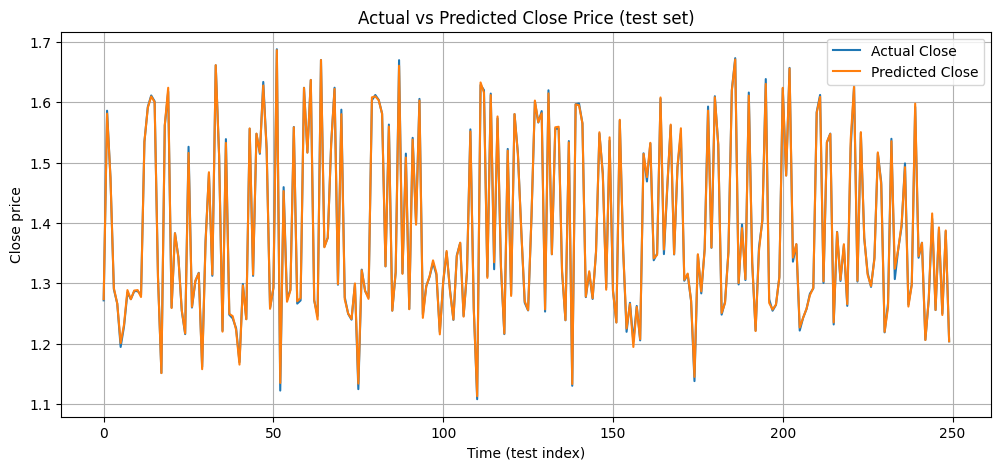

In [29]:
# ------------------------------------------------------------
# USAGE (example)
# ------------------------------------------------------------
# Assumptions:
# - x_test shape = (n_samples, window_len, n_features) e.g. (6247, 48, 4)
# - y_test shape = (n_samples, n_features) e.g. (6247, 4)
# - model.predict(x_test) -> (n_samples, n_features) (or shape convertible)
#
# Optional:
# - scaler_X (used during training on inputs) or scaler_y (used on outputs).
#   If present, inverse_transform predictions and y_test before plotting.
#
# Replace these names with your actual variables present in the workspace.

# Example (uncomment and run where variables exist):
preds_test = best_model.predict(X_test)
preds_test = ensure_2d_preds(preds_test)

# # 1) plot actual vs predicted (test)
plot_test_vs_pred_close(y_test, preds_test, output_index=-1, savepath='test_vs_pred.png')


In [ ]:
#
# # 2) recursive forecast next 2000 values starting from last input window:
last_window = X_test[-1]   # shape (window_len, n_features)
future_preds = recursive_forecast(best_model, last_window, n_steps=2000)
future_preds_inv = future_preds

# # 3) plot extended series (append future close to test close)
plot_extended_series(y_test, future_preds_inv, output_index=-1, savepath='extended_forecast.png')
#
# # Optional: save future_preds_inv to disk
# # np.save('future_preds.npy', future_preds_inv)